# Spearman correlation
AIDS: Dados provenientes de http://www2.aids.gov.br/cgi/deftohtm.exe?tabnet/sp.def

TUBERCULOSE: Dados provenientes de http://tabnet.datasus.gov.br (cabeçalhos adaptados)

ONCOLOGIA: http://tabnet.datasus.gov.br/cgi/webtabx.exe?PAINEL_ONCO/PAINEL_ONCOLOGIABR.def

VIOLENCIA: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sinannet/cnv/violebr.def

Import libraries

In [1]:
import pandas as pd
import glob
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
    

Read suicide csv

In [33]:
suicide = pd.read_csv('../Suicide/CSV/suicide_rate_codmunres.csv', sep=',')

Read disease files

In [38]:
year = "2017"
disease = ""
all_files = glob.glob("CSV/Rates/*.csv")

diseases_list = []
corrs_list = []
p_value_list = []
sizes_list = []
path = 'CSV/Rates/'
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("BR")[0]
    disease_df = pd.read_csv(path + disease + 'BR' + year + '_RATE.csv', sep=',')
    disease_df = disease_df[["QUANTIDADE_RATE", "MUNCOD"]]
    
    # Merge Files
    result_df = pd.merge(disease_df, suicide, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
    result_df = result_df[["QUANTIDADE_RATE", "SUICIDE_RATE"]]
    
    # Spearman correlation
    file_array = result_df.iloc[:,0].values
    suicides_array = result_df.iloc[:,1].values
    corr, p_value = spearmanr(file_array,suicides_array)
    
    # Append correlation
    sizes_list.append(result_df.shape[0])
    diseases_list.append(disease)
    corrs_list.append(corr)
    p_value_list.append(p_value)

Spearman correlations table

In [39]:
corrs_data = {'Doenças': diseases_list, 'Correlação com suicidio': corrs_list, 'P value': p_value_list, 'Número de municípios': sizes_list}
corrs_df = pd.DataFrame(data=corrs_data)
corrs_df

,Doenças,Correlação com suicidio,P value,Número de municípios
0,AIDS,0.181625,1.826353e-12,1483
1,AIDS_SINAN,0.142361,5.867226e-11,2096
2,ASMA,0.202740,2.203718e-25,2585
3,CANCER_PAINEL,0.265570,1.055121e-50,3069
4,CARDIACA,0.200876,1.743483e-29,3089
5,DENGUE,0.108056,2.831428e-07,2247
6,DIABETES,0.207459,1.743129e-31,3100
7,DORSOPATIA,0.391941,4.690499e-67,1797
8,DPOC,0.345793,6.700904e-83,2924
9,ENXAQUECA,0.323917,1.591717e-33,1316


Table with diseases and suicide numbers merged per city

In [76]:
all_diseases = suicide[["SUICIDE_RATE", "CODMUNRES"]]
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("BR")[0]
    disease_df = pd.read_csv(path + disease + 'BR' + year + '_RATE.csv', sep=',')
    disease_df = disease_df[["QUANTIDADE_RATE", "MUNCOD"]]
    disease_df.rename(columns={"QUANTIDADE_RATE": disease}, inplace=True)
    
    # Merge with current dataframe
    all_diseases = pd.merge(disease_df, result, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
    all_diseases.drop('MUNCOD', axis=1, inplace=True)
# Add SUICIDES to columns
all_diseases

,VIOLENCIA_x,VIOLENCIA_y,TUBERCULOSE,MENTAL,DENGUE,CANCER,AIDS,SUICIDE_RATE,CODMUNRES
0,86.636546,86.636546,33.536727,85.704970,55.894546,61.484000,23.289394,9.315758,110002
1,37.285186,37.285186,29.376208,36.155332,27.116499,150.270600,10.168687,5.649271,110004
2,75.199873,75.199873,71.241985,39.578881,126.652418,110.820866,39.578881,7.915776,110080
3,27.880004,27.880004,11.152002,27.880004,1410.728226,83.640013,22.304004,5.576001,110005
4,37.760785,37.760785,18.880393,37.760785,18.880393,103.842160,18.880393,9.440196,110092
...,...,...,...,...,...,...,...,...,...
1435,119.754503,119.754503,12.474427,47.402824,396.686792,72.351679,17.464198,9.979542,522160
1436,49.313138,49.313138,7.044734,70.447341,317.013033,49.313138,14.089468,7.044734,522170
1437,143.573668,143.573668,19.435737,50.783699,260.815047,39.498433,11.912226,3.761755,522185
1438,21.937843,21.937843,7.312614,212.065814,263.254113,73.126143,7.312614,7.312614,522200


Heatmap of the diseases and suicide

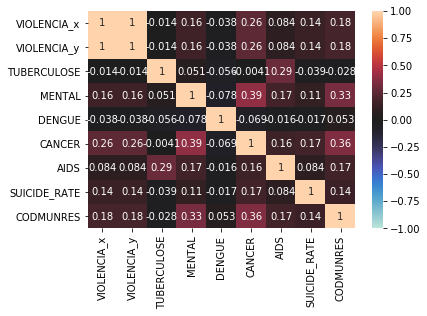

In [77]:
sns.heatmap(all_diseases.corr(), annot=True, vmin=-1, vmax=1, center=0)

## Scatter Plot
Scatter plot to visualize relationship between suicide and hospital adminissions for mental conditions

Load file

In [78]:
disease_df = pd.read_csv('CSV/Quantity/MENTALBR2017.csv', sep=',')
suicide_df = pd.read_csv('../Suicide/CSV/suicides_codmunres.csv')

Merge files

In [82]:
result = pd.merge(disease_df, suicide_df, left_on="MUNCOD", right_on="CODMUNRES", how="inner")
result = result[["QUANTIDADE", "SUICIDES"]]

Plot

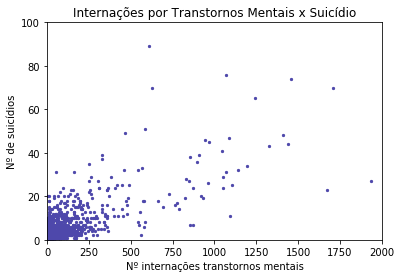

In [83]:
plt.scatter(result["QUANTIDADE"], result["SUICIDES"], s=5, color='#4e48ab')
plt.xlabel("Nº internações transtornos mentais")
plt.ylabel("Nº de suicídios")
plt.title("Internações por Transtornos Mentais x Suicídio")
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([0,100])
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#f8fafb'
plt.rcParams['savefig.facecolor'] = '#33364f'
